In [1]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
import utils
from utils import keras_baselilne
from utils import resnet
%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#Load data
train = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/train.json")
train_final = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/train_final.json")
valid = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/valid.json")
test = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train/test.json")
train = pd.concat([train,train_final])
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
valid.inc_angle = valid.inc_angle.replace('na', 0)
valid.inc_angle = valid.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [3]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Valid data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_2"]])
X_valid = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_valid = np.array(valid.inc_angle)
y_valid = np.array(valid["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

In [4]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    

reload(utils)
model = resnet()
model.summary()

utils.py:249: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  input_CNN_residual = merge([input_CNN_residual,input_CNN], mode = 'sum')
/home/user/tensorflow/local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 32)   2432        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 75, 75, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [6]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 1s     


In [14]:
prediction = pd.read_csv('/mnt/extDisk/courses/data/statoil/data/ensamble/ensamble_0211.csv')

In [15]:
print(prediction.head())
print(len(test))
test_label = pd.merge(test,prediction,on=['id'])
print(len(test_label))
print(len(test_label[(test_label.is_iceberg < 0.02) | (test_label.is_iceberg >0.98)]))
test_label = test_label[(test_label.is_iceberg < 0.02) | (test_label.is_iceberg >0.98)]
#test_label = test_label[[(len(str(x).split('.')[1]) < 5) for x in test_label['inc_angle']]]

x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_label["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_label["band_2"]])
X_test_label = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test_label = np.array(test_label.inc_angle)
test_y = np.array(test_label["is_iceberg"])

         id  is_iceberg
0  000c65d7    0.840560
1  001680af    0.209411
2  00193999    0.883449
3  00247e48    0.990012
4  00503faa    0.000414
8424
8424
2274


In [16]:
X_mix = np.concatenate([X_train,X_test_label])
X_angle_mix = np.concatenate([X_angle_train,X_angle_test_label])
y_mix = np.concatenate([y_train,test_y])

In [8]:
#layers = model.layers
# Get the index of the first dense layer...
#first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
#for layer in layers[first_dense_idx:]: layer.trainable=True

In [18]:
file_path = "/mnt/extDisk/courses/data/statoil/data/models/.pseudo_full.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)
reload(utils)
model = utils.resnet()
model.fit(X_mix, y_mix, epochs=20
          , validation_data=(X_valid, y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 3678 samples, validate on 200 samples
Epoch 1/20
3678/3678 [==============================] - 7s 2ms/step - loss: 0.4839 - acc: 0.2621 - val_loss: 2.1172 - val_acc: 0.5650
Epoch 2/20
3678/3678 [==============================] - 5s 1ms/step - loss: 0.2511 - acc: 0.3072 - val_loss: 0.5053 - val_acc: 0.7700
Epoch 3/20
3678/3678 [==============================] - 5s 1ms/step - loss: 0.1720 - acc: 0.3238 - val_loss: 0.3928 - val_acc: 0.8700
Epoch 4/20
3678/3678 [==============================] - 5s 1ms/step - loss: 0.1756 - acc: 0.3233 - val_loss: 0.2664 - val_acc: 0.8750
Epoch 5/20
3678/3678 [==============================] - 4s 1ms/step - loss: 0.1383 - acc: 0.3377 - val_loss: 0.4984 - val_acc: 0.8050
Epoch 6/20
3678/3678 [==============================] - 5s 1ms/step - loss: 0.1412 - acc: 0.3382 - val_loss: 0.5263 - val_acc: 0.8100
Epoch 7/20
3678/3678 [==============================] - 4s 1ms/step - loss: 0.1319 - acc: 0.3363 - val_loss: 0.8895 - val_acc: 0.6900
Epoch 8/20
3678

In [17]:
model.load_weights(filepath=file_path)

optimizer = Adam(lr=0.000001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit([X_train, X_angle_train], y_train, epochs=25
          , validation_data=([X_valid,X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[[-27.87836075, -27.15411758, -27.87836075],
         [-27.15415955, -29.53788757, -27.15415955],
         [-28.66861534, -31.03059959, -28.66861534],
         ..., 
         [-25.57348251, -...

In [19]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate(X_train, y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate(X_valid, y_valid, verbose=1, batch_size=200))

Train evaluate:
1404/1404 [==============================] - 1s 390us/step
[0.10241176870431316, 0.97222218927834447]
####################
watch list evaluate:
200/200 [==============================] - 0s 262us/step
[0.24916231632232666, 0.90500003099441528]


In [21]:
prediction = model.predict(X_test, verbose=1, batch_size=200)

8424/8424 [==============================] - 2s 294us/step


In [66]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,3.261286e-02
1,4023181e,3.330509e-02
2,b20200e4,6.682109e-07
3,e7f018bb,9.683403e-01
4,4371c8c3,1.214303e-02
5,a8d9b1fd,1.975131e-02
6,29e7727e,3.376642e-01
7,92a51ffb,9.836701e-01
8,c769ac97,2.740420e-03
9,aee0547d,7.369975e-04


In [67]:
submission.to_csv("/mnt/extDisk/courses/data/statoil/data/train/pseu_label_sure_keras_box_angle.csv", index=False)

In [162]:
valid_prediction = model.predict([X_valid, X_angle_valid], verbose=1, batch_size=200)

200/200 [==============================] - 3s


In [163]:
vaild_df = valid
vaild_df['prediction'] = valid_prediction

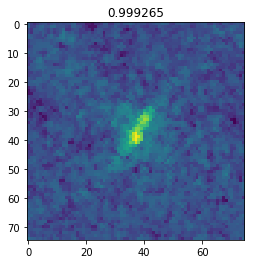

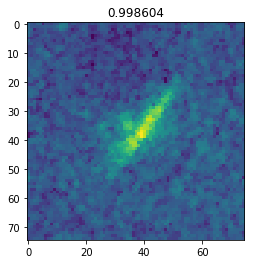

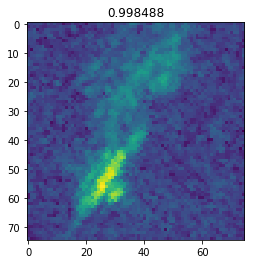

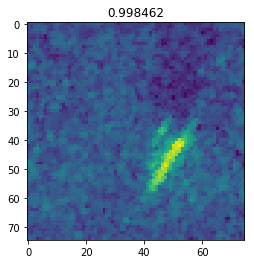

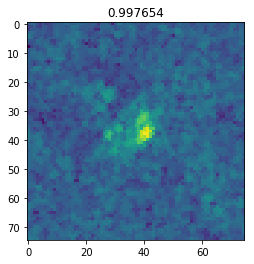

In [164]:
reload(utils)
utils.true_positive(vaild_df)

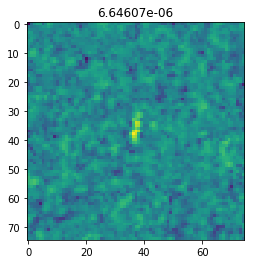

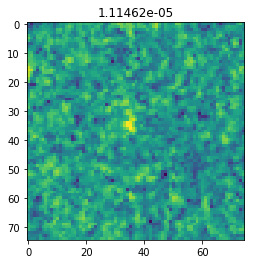

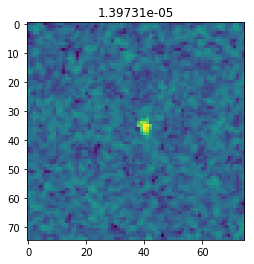

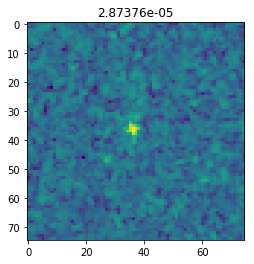

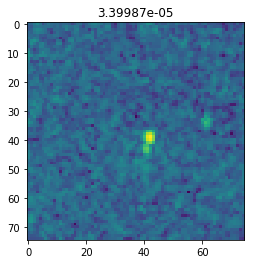

In [165]:
reload(utils)
utils.true_negetive(vaild_df)

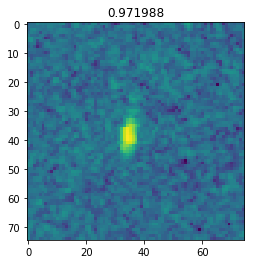

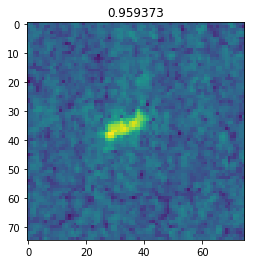

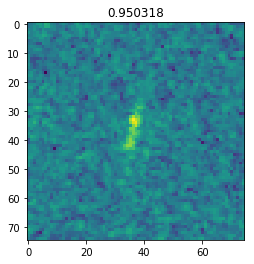

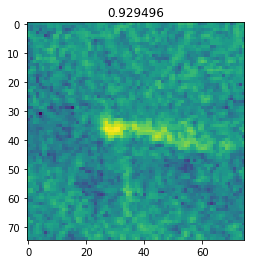

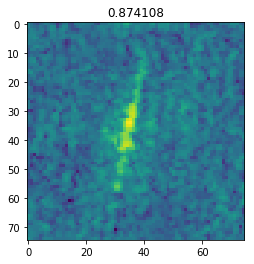

In [166]:
reload(utils)
utils.false_positive(vaild_df)

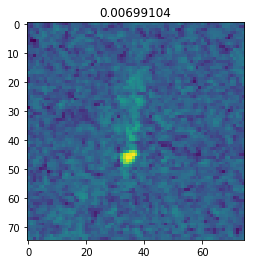

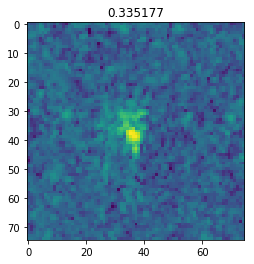

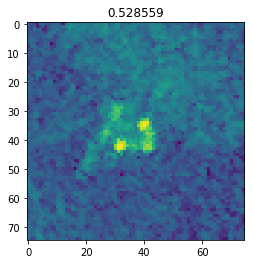

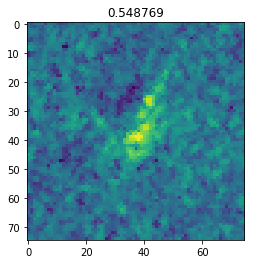

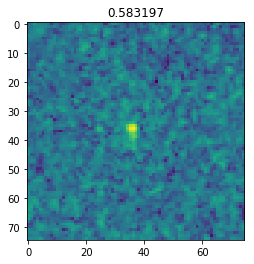

In [167]:
reload(utils)
utils.false_negative(vaild_df)

In [8]:
print(len(test_label[(test_label.is_iceberg < 0.02) | (test_label.is_iceberg >0.98)]))

0


id            fff77564
is_iceberg    0.974976
dtype: object